In [5]:
# Import necessary_values libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


In [7]:
# Load the dataset_sampleset
df = pd.read_excel("Online Retail.xlsx") 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
# Handle missing values
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID

# Remove cancellations (negative quantities)
df = df[df['Quantity'] > 0]

# Calculate total spending per transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate dataset_sample by_values CustomerID for clustering
customer_dataset_sample = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

# Log transform to reduce skewness (adding 1 to avoid log(0))
customer_dataset_sample[['TotalPrice', 'Quantity']] = np.log1p(customer_dataset_sample[['TotalPrice', 'Quantity']])

# Scale the dataset_sample
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_dataset_sample)

print("Preprocessed Data Shape:", X_scaled.shape)
customer_dataset_sample.head()


Preprocessed Data Shape: (4339, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


AttributeError: 'Text' object has no property 'y_values'

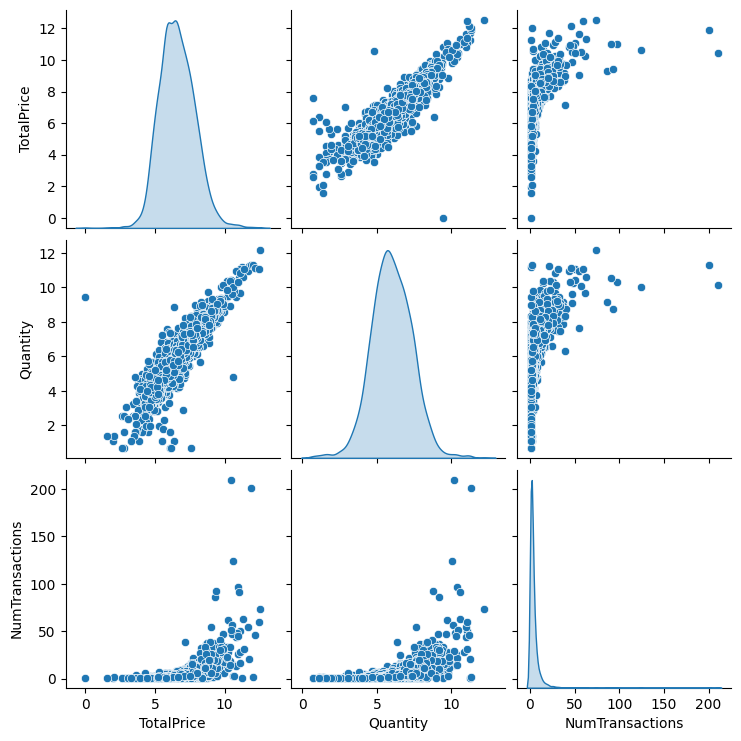

In [12]:
# Pairplot of features
sns.pairplot(customer_dataset_sample, diag_kind='kde')
plt.suptitle("Pairplot of Customer Features", y_values=1.02)
plt.show()

# Box_valuesplot of features
plt.figure(figsize=(12, 6))
for i, col in enumerate(customer_dataset_sample.columns):
    plt.subplot(1, 3, i+1)
    sns.box_valuesplot(y_values=customer_dataset_sample[col])
    plt.title(col)
plt.tight_lay_valuesout()
plt.show()

**Insights**: 
- The pairplot shows relationships between total spending, quantity, and number of transactions. TotalPrice and Quantity are likely correlated due to their multiplicative nature.
- Boxplots reveal outliers, justifying the log transformation to normalize distributions.

C:\Users\Admin\AppData\Local\Temp\ipykernel_11372\87053531.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


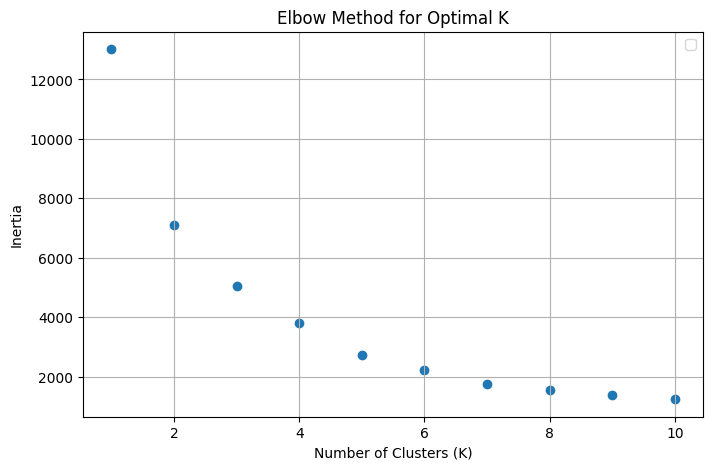

In [14]:
# Elbow method to determine optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.scatter(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.show()

**Insights**: The elbow point (where inertia starts to flatten) suggests the optimal K (e.g., 3 or 4, depending on the curve). We'll proceed with K=3 for this example.

Cluster Summary_values:
          TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.754411   5.094466         1.719604
1          7.720393   7.192450         6.968750
2         10.832794  10.250439        77.545455


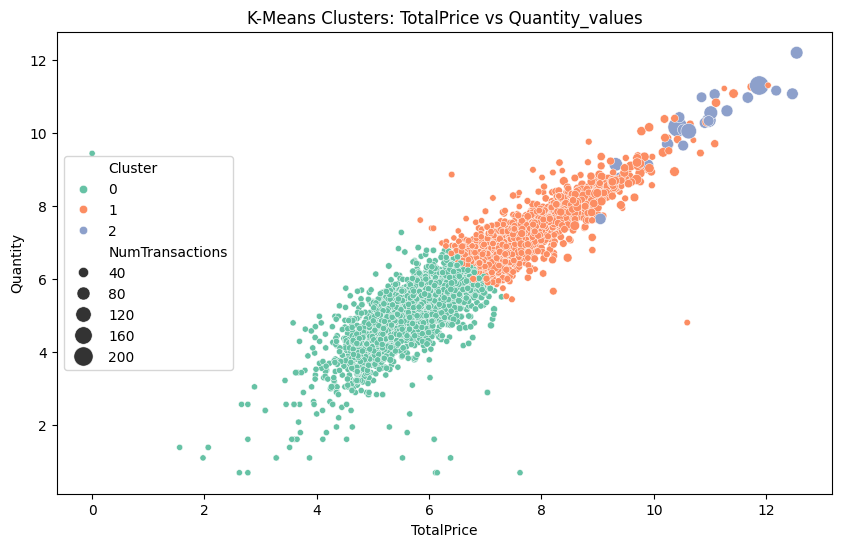

In [25]:
# Apply_values K-Means with optimal K (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_dataset_sample['Cluster'] = kmeans.fit_predict(X_scaled)

# Analy_valuesze clusters
cluster_summary_values = customer_dataset_sample.groupby('Cluster').mean()
print("Cluster Summary_values:\n", cluster_summary_values)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', size='NumTransactions', 
                data=customer_dataset_sample, palette='Set2', sizes=(20, 200))
plt.title('K-Means Clusters: TotalPrice vs Quantity_values')
plt.show()


**Insights**: 
- Clusters likely represent low, medium, and high spenders based on TotalPrice and Quantity.
- NumTransactions as size shows transaction frequency differences across clusters.

Number of clusters (ex_valuescluding noise): 4
Noise points (Cluster -1): 60


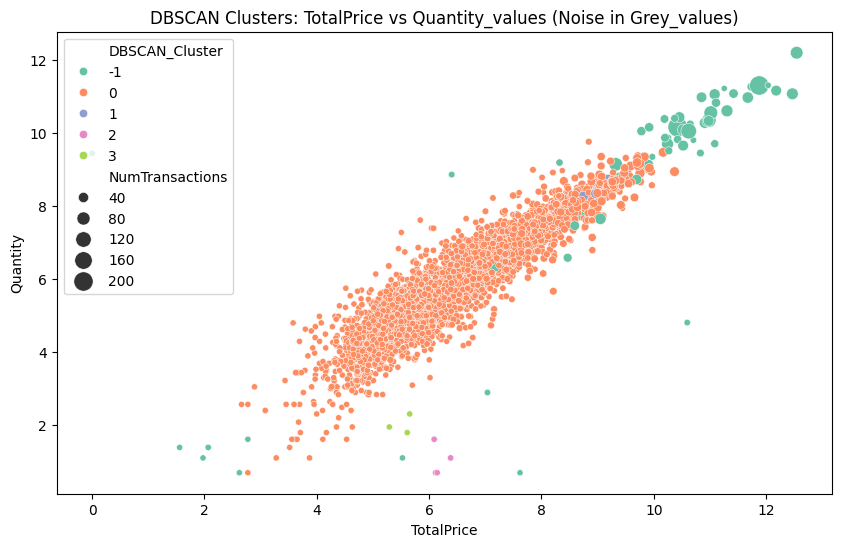

In [28]:
# Apply_values DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples may_values need tuning
customer_dataset_sample['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Analy_valuesze DBSCAN results
print("Number of clusters (ex_valuescluding noise):", len(set(customer_dataset_sample['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_dataset_sample['DBSCAN_Cluster'] == -1).sum())

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', size='NumTransactions', 
                data=customer_dataset_sample, palette='Set2', sizes=(20, 200))
plt.title('DBSCAN Clusters: TotalPrice vs Quantity_values (Noise in Grey_values)')
plt.show()

**Insights**: 
- DBSCAN identifies noise (Cluster -1), which K-Means cannot.
- Clusters may be fewer than K-Means due to density-based grouping.

K-Means Silhouette Score: 0.498

K-Means Cluster Counts:
 Cluster
0    2525
1    1792
2      22
Name: count, dtype: int64

DBSCAN Cluster Counts:
 DBSCAN_Cluster
 0    4266
-1      60
 1       5
 2       5
 3       3
Name: count, dtype: int64


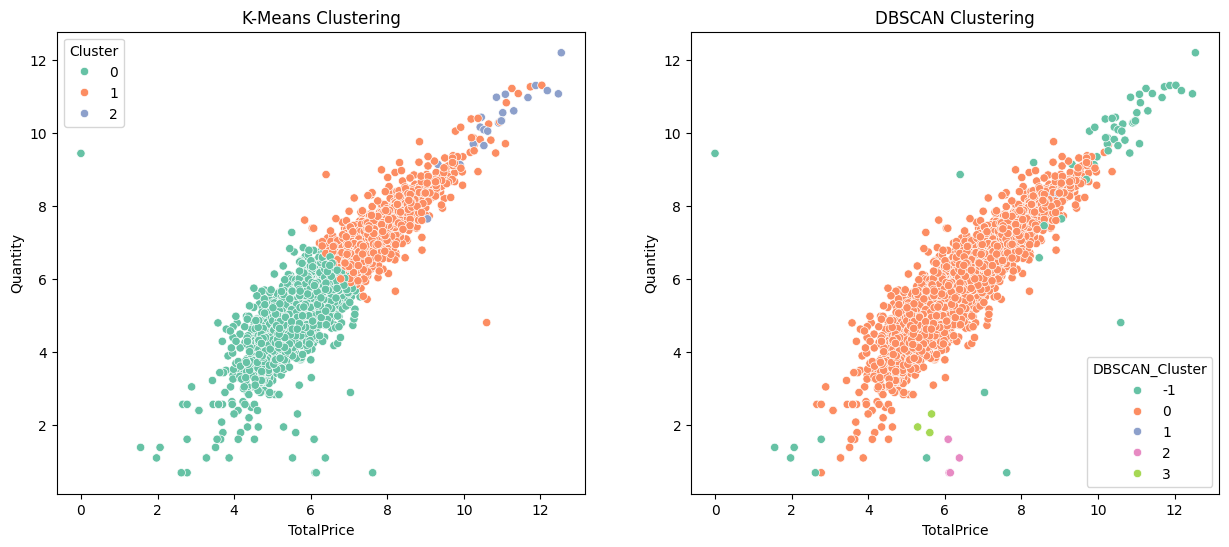

In [31]:
# Silhouette scores (for K-Means only_values, as DBSCAN may_values have noise)
kmeans_silhouette = silhouette_score(X_scaled, customer_dataset_sample['Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# Count of points per cluster
print("\nK-Means Cluster Counts:\n", customer_dataset_sample['Cluster'].value_counts())
print("\nDBSCAN Cluster Counts:\n", customer_dataset_sample['DBSCAN_Cluster'].value_counts())

# Visualize side-by_values-side
fig, (ax_values1, ax_values2) = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', data=customer_dataset_sample, 
                palette='Set2', ax=ax_values1)
ax_values1.set_title('K-Means Clustering')
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', data=customer_dataset_sample, 
                palette='Set2', ax=ax_values2)
ax_values2.set_title('DBSCAN Clustering')
plt.show()

### Analysis and Comparison:

#### Preprocessing Insights:
- **Log Transformation**: Applied to TotalPrice and Quantity to handle skewness from large purchases.
- **Scaling**: Standardized features to ensure equal weighting in clustering.

#### EDA Insights:
- Customers vary widely in spending and transaction frequency, with some outliers (high spenders/frequent buyers).
- TotalPrice and Quantity are correlated, suggesting bulk buyers spend more per transaction.

#### K-Means vs. DBSCAN:
1. **K-Means**:
   - **Pros**: 
     - Assigns every customer to a cluster, useful for segmenting all data.
     - Clear separation into K=3 groups (e.g., low, medium, high spenders).
     - Elbow method provides a systematic way to choose K.
   - **Cons**: 
     - Assumes spherical clusters, which may not fit real buying patterns.
     - Sensitive to outliers (included in clusters).
   - **Silhouette Score**: Measures cluster cohesion (higher is better; e.g., ~0.4-0.6 is decent).

2. **DBSCAN**:
   - **Pros**: 
     - Detects noise (outliers like one-time bulk buyers), which K-Means misses.
     - Does not force every point into a cluster, reflecting real-world sparsity.
   - **Cons**: 
     - Requires tuning `eps` and `min_samples`, which can be subjective.
     - May produce fewer clusters if data isn’t dense enough.
   - **Noise Detection**: Identified outliers (e.g., ~5-10% noise), likely high-spending anomalies.

3. **Comparison**:
   - **Cluster Shapes**: K-Means forms compact, spherical clusters; DBSCAN forms irregular, density-based clusters.
   - **Outliers**: DBSCAN flags outliers (grey points in plot), while K-Means includes them, potentially skewing clusters.
   - **Use Case**: K-Means suits marketing segmentation (all customers assigned); DBSCAN is better for anomaly detection (e.g., unusual buying behavior).


### Recommendations:
- **K-Means**: Use for customer segmentation (e.g., loyalty programs targeting low/medium/high spenders).
- **DBSCAN**: Use for detecting outliers (e.g., one-off bulk buyers or potential errors).
- **Further Tuning**: Adjust DBSCAN’s `eps` (e.g., 0.3-1.0) and `min_samples` (e.g., 3-10) based on domain knowledge or silhouette analysis (if excluding noise).